In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Identification").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.sql("USE 2023_04_01")





DataFrame[]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, lit, udf, pandas_udf, PandasUDFType, coalesce, \
            month, year, concat, date_format, format_string, last_day, months_between, greatest, least, when, lag, count, desc, expr, log1p
from pyspark.sql.window import Window
from datetime import timedelta
from pyspark.sql.types import*
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import csv
import math
import pyspark.pandas as ps

/opt/spark/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [3]:
def get_all_stocks_prices():
    query = """SELECT s.ticker_region, p.p_date, p.p_price, splits.p_split_date, splits.p_split_factor
                FROM sym_ticker_region s 
                INNER JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                INNER JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                INNER JOIN fp_basic_prices p ON p.fsym_id = sc.fsym_regional_id
                LEFT JOIN fp_basic_splits AS splits ON splits.p_split_date = p.p_date AND p.fsym_id = splits.fsym_id 
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")
                AND p.p_date >= '2000-01-01'
                ORDER BY s.ticker_region, p.p_date
                """
    adj = spark.sql(query)
    
    window_spec = Window.partitionBy('ticker_region').orderBy(col('p_date').desc())
    adj = adj.withColumn("cum_split_factor", lit(0.0))  # placeholders
    adj = adj.withColumn("cum_split_factor", when(col('p_date') == col('p_split_date'), col('p_split_factor')).otherwise(lit(1.0)))
    adj = adj.withColumn("cum_split_factor", lit(1.0) * lag("cum_split_factor").over(window_spec)).fillna(1.0)

    # Calculate split-adjusted price
    adj = adj.withColumn("split_adj_price", col("p_price") * col("cum_split_factor"))

    # Sort the DataFrame
    adj = adj.sort(col('ticker_region').asc(), col('p_date').asc())

    # Drop unnecessary columns
    # columns_to_drop = ["fsym_id", "p_split_date", 'p_split_factor']
    # adj = adj.drop(*columns_to_drop)
    
    adj.filter(col('ticker_region')=='AAPL-US').show()
    

    
#get_all_stocks_prices()
    

In [4]:
def get_stock_price_weekly(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start='2000-01-01', end='2023-03-31', progress=False)
    if temp_df.empty:
        print("No data available for the specified date range.")
        return None
    print(temp_df['Adj Close'].pct_change())

#get_stock_price_weekly('AAPL')

In [5]:
# adj = spark.sql("""SELECT s.fsym_id, str.ticker_region, sc.proper_name, p.p_date, p.p_price,
#                 splits.p_split_date, splits.p_split_factor

# FROM sym_entity_sector AS e

# INNER JOIN fp_sec_entity AS s ON e.factset_entity_id = s.factset_entity_id
# INNER JOIN sym_coverage AS sc ON s.fsym_id = sc.fsym_security_id 
# INNER JOIN fp_basic_prices AS p ON sc.fsym_regional_id = p.fsym_id
# INNER JOIN factset_sector_map AS sm ON e.sector_code = sm.factset_sector_code
# INNER JOIN ff_basic_qf AS ff ON p.fsym_id = ff.fsym_id
# INNER JOIN ff_advanced_der_af adf ON p.fsym_id = adf.fsym_id
# LEFT JOIN sym_ticker_region str ON str.fsym_id = sc.fsym_regional_id
# LEFT JOIN fp_basic_dividends AS divs ON divs.p_divs_exdate = p.p_date AND p.fsym_id = divs.fsym_id
# LEFT JOIN fp_basic_splits AS splits ON splits.p_split_date = p.p_date AND p.fsym_id = splits.fsym_id 

# WHERE sc.fsym_security_id IS NOT NULL
#         AND sc.fref_security_type IS NOT NULL AND sc.fref_security_type = 'SHARE'
#         AND sc.currency IS NOT NULL AND sc.currency = 'USD'
#         AND s.factset_entity_id IS NOT NULL
#         AND p.p_date IS NOT NULL
#         AND (sc.fref_listing_exchange = 'NAS' OR sc.fref_listing_exchange = 'NYS')
#         AND p.p_date >= '2000-01-01'
#         AND str.ticker_region = 'AAPL-US'
# ORDER BY s.fsym_id ASC, p_date DESC
#             """)


# adj = adj.withColumn("temp_cum_split_factor", when(adj.p_date==adj.p_split_date, lit(adj.p_split_factor)).otherwise(lit(1.0)))
# adj = adj.withColumn("div_split_factor", lit(0.0)) # placeholders
# adj = adj.withColumn("cum_split_factor", lit(0.0)) # placeholders
# adj = adj.withColumn("split_temp_i", lit(0)) # placeholders - for ordering purposes

# # creating udf to calculate cumulative split factor
# @pandas_udf(adj.schema, FloatType(), PandasUDFType.GROUPED_MAP)
# def calc_product_factor(df1):
#     """
#     Calculates the cumulative split factor for each company based on unique fsym_id's,
#     for both the price split and the dividend split.
#     The data MUST be sorted within the function itself (no orderBy in the function call),
#     and spin_temp_i must be set to i during each iteration of the loop to guarantee
#     proper sorting - without these safeguards, the function is applied non-sequentially
#     to the data.
#     """
#     df1 = df1.sort_values(by='p_date', ascending=False)
#     for i in range(0, len(df1)):
#         df1.loc[i, 'split_temp_i'] = i
#         if i == 0:
#             df1.loc[i, 'cum_split_factor'] = 1.0
#             df1.loc[i, 'div_split_factor'] = 1.0
#             continue
#         df1.loc[i-1, 'div_split_factor'] = df1.loc[i-1, 'cum_split_factor'] * df1.loc[i-1, 'temp_cum_split_factor']
#         df1.loc[i, 'cum_split_factor'] = df1.loc[i-1, 'cum_split_factor'] * df1.loc[i-1, 'temp_cum_split_factor']
#     return df1

# adj = adj.groupBy('fsym_id').apply(calc_product_factor)
# adj = adj.withColumn("split_adj_price", (adj.p_price*adj.cum_split_factor))

# adj.filter(col('ticker_region')=='AAPL-US').orderBy('fsym_id', 'p_date').show()

In [6]:

def get_all_stocks_df():
    query = f"""SELECT s.ticker_region, s.fsym_id,p.p_date, p.p_price, splits.p_split_date, splits.p_split_factor FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                INNER JOIN fp_basic_prices p ON p.fsym_id = sc.fsym_regional_id
                LEFT JOIN fp_basic_splits AS splits ON splits.p_split_date = p.p_date AND p.fsym_id = splits.fsym_id 
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS") AND p.p_date >= '2000-01-01'
                ORDER BY s.fsym_id, p.p_date"""
    

    adj = spark.sql(query)
    adj = adj.withColumn("temp_cum_split_factor", when(adj.p_date==adj.p_split_date, lit(adj.p_split_factor)).otherwise(lit(1.0)))
    #adj = adj.withColumn("div_split_factor", lit(0.0)) # placeholders
    adj = adj.withColumn("cum_split_factor", lit(0.0)) # placeholders
    #adj = adj.withColumn("split_temp_i", lit(0)) # placeholders - for ordering purposes

    window_spec = Window.partitionBy('fsym_id').orderBy(F.desc('p_date'))

    # Calculate cumulative split factor and dividend split factor
    #adj = adj.withColumn('split_temp_i', F.row_number().over(window_spec) - 1)
    adj = adj.withColumn('cum_split_factor_no_lag', 
                        F.exp(F.sum(F.log('temp_cum_split_factor')).over(window_spec)))

    # Apply lag to the calculated cumulative split factor
    adj = adj.withColumn('cum_split_factor', 
                        F.when(F.row_number().over(window_spec) == 1, 1.0)
                        .otherwise(F.lag('cum_split_factor_no_lag', default=1.0).over(window_spec)))

    adj = adj.withColumn('split_adj_price', adj.p_price * adj.cum_split_factor)
    
    adj = adj.withColumn('year', F.year('p_date'))
    
    adj =adj.withColumn('week_of_year', F.weekofyear('p_date'))

    window_spec = Window.partitionBy('fsym_id', 'year', 'week_of_year').orderBy(col('p_date').desc())

    adj = adj.withColumn('row_num', F.row_number().over(window_spec))

    adj = adj.filter(col('row_num') == 1)
    
    
    # adj_pd = adj.toPandas()
    # adj_pd['p_date'] = pd.to_datetime(adj_pd['p_date'])

    # plt.figure(figsize=(15, 5))
    # plt.plot(adj_pd['p_date'], adj_pd['split_adj_price'], label='AAPL adjusted')
    # plt.plot(adj_pd['p_date'], adj_pd['p_price'], label='AAPL unadjusted')
    # plt.legend()
    # plt.show()


    adj = adj.drop('temp_cum_split_factor', 'cum_split_factor', 'cum_split_factor_no_lag', 'row_num', 'p_split_date', 'p_split_factor')
    adj = adj.withColumn('Implosion_Start_Date', F.lit(None).cast(DateType()))
    adj = adj.withColumn('Implosion_End_Date', F.lit(None).cast(DateType()))
    
    window_spec2 = Window().partitionBy('fsym_id').orderBy('p_date').rowsBetween(-52, Window.currentRow)
    adj = adj.withColumn('rolling_mean', F.avg('split_adj_price').over(window_spec2))
    
    
    adj.orderBy('fsym_id', 'p_date').show()
    
    
    
    @pandas_udf(adj.schema, FloatType(), PandasUDFType.GROUPED_MAP)
    def find_implosion(df1):
        fsym_id = df1.loc[0,'fsym_id']
        df1 = df1.sort_values(by='p_date')
        i = 52
        price_drop_thresh = -0.6
        period_thresh = 78
        imp_dates = []
        while i < len(df1):
            current_date = df1.loc[i, 'p_date']
            current_price = df1.loc[i, 'split_adj_price']
            mean_price = df1.loc[i, 'rolling_mean']
            print(current_date, current_price, mean_price)
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                j = i
                start_price=current_price
                j+=1
                imp_period=0
                while j < len(df1) and (df1.loc[j, 'split_adj_price'] - start_price) / start_price <= 0.2:
                    imp_period+=1
                    j+=1
                if imp_period > period_thresh:
                    imp_dates.append((current_date, df1.loc[i+imp_period, 'p_date']))
                i+=imp_period
            i+=1
        if len(imp_dates)>0:
            df1.loc[df1['fsym_id']==fsym_id, 'Implosion_Start_Date'] = imp_dates[0][0]
            df1.loc[df1['fsym_id']==fsym_id, 'Implosion_End_Date'] = imp_dates[0][1]
        
        return df1
    
    def find_implosion2(df1):
        
        fsym_id = df1.loc[0,'fsym_id']
        df1 = df1.sort_values(by='p_date')
        print(df1.head())
        i = 52
        price_drop_thresh = -0.6
        period_thresh = 78
        imp_dates = []
        while i < len(df1):
            current_date = df1.loc[i, 'p_date']
            current_price = df1.loc[i, 'split_adj_price']
            mean_price = df1.loc[i, 'rolling_mean']
            print(current_date, current_price, mean_price)
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                print('here')
                j = i
                start_price=current_price
                j+=1
                imp_period=0
                while j < len(df1) and (df1.loc[j, 'split_adj_price'] - start_price) / start_price <= 0.2:
                    imp_period+=1
                    j+=1
                print(imp_period)
                if imp_period > period_thresh:
                    print("IMPLOSION")
                    imp_dates.append((current_date, df1.loc[i+imp_period, 'p_date']))
                i+=imp_period
            i+=1
        if len(imp_dates)>0:
            df1.loc[df1['fsym_id']==fsym_id, 'Implosion_Date'] = imp_dates[0][0]
            print(imp_dates[0][0])
        
        return df1
    

    # adj = adj.filter(col('ticker_region')=='AAPL-US').orderBy('fsym_id', 'p_date')
    # find_implosion2(ps.DataFrame(adj))
    adj = adj.groupBy('fsym_id').apply(find_implosion)
    result_df = adj.groupBy('ticker_region').agg(F.first('Implosion_Start_Date').alias('Implosion_Start_Date'), F.first('Implosion_End_Date').alias('Implosion_End_Date'))
    result_df.show()
    result_df.toPandas().to_csv('imploded_stocks3.csv')
    
    

    #adj.show()
    
    
    
    
    
get_all_stocks_df()

+-------------+--------+----------+-------+---------------+----+------------+--------------------+------------------+------------------+
|ticker_region| fsym_id|    p_date|p_price|split_adj_price|year|week_of_year|Implosion_Start_Date|Implosion_End_Date|      rolling_mean|
+-------------+--------+----------+-------+---------------+----+------------+--------------------+------------------+------------------+
|      PBFX-US|B00FG1-R|2014-05-09|  27.68|          27.68|2014|          19|                null|              null|             27.68|
|      PBFX-US|B00FG1-R|2014-05-16|  26.92|          26.92|2014|          20|                null|              null|              27.3|
|      PBFX-US|B00FG1-R|2014-05-23|  26.74|          26.74|2014|          21|                null|              null|27.113333333333333|
|      PBFX-US|B00FG1-R|2014-05-30|  26.75|          26.75|2014|          22|                null|              null|           27.0225|
|      PBFX-US|B00FG1-R|2014-06-06|  28.8

/opt/spark/python/pyspark/sql/pandas/group_ops.py:103: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


+-------------+--------------------+------------------+
|ticker_region|Implosion_Start_Date|Implosion_End_Date|
+-------------+--------------------+------------------+
|      BIDU-US|                null|              null|
|      DDDP-US|                null|              null|
|      PTLO-US|                null|              null|
|       CGO-US|                null|              null|
|       TOP-US|                null|              null|
|      RTLX-US|                null|              null|
|      ANDS-US|                null|              null|
|      ORGN-US|                null|              null|
|      PCYG-US|          2002-08-02|        2004-02-13|
|     CLRCU-US|                null|              null|
|       FBC-US|          2008-10-17|        2022-11-30|
|     CFVIU-US|                null|              null|
|      ALLY-US|                null|              null|
|      AIXI-US|                null|              null|
|      PGNX-US|                null|            

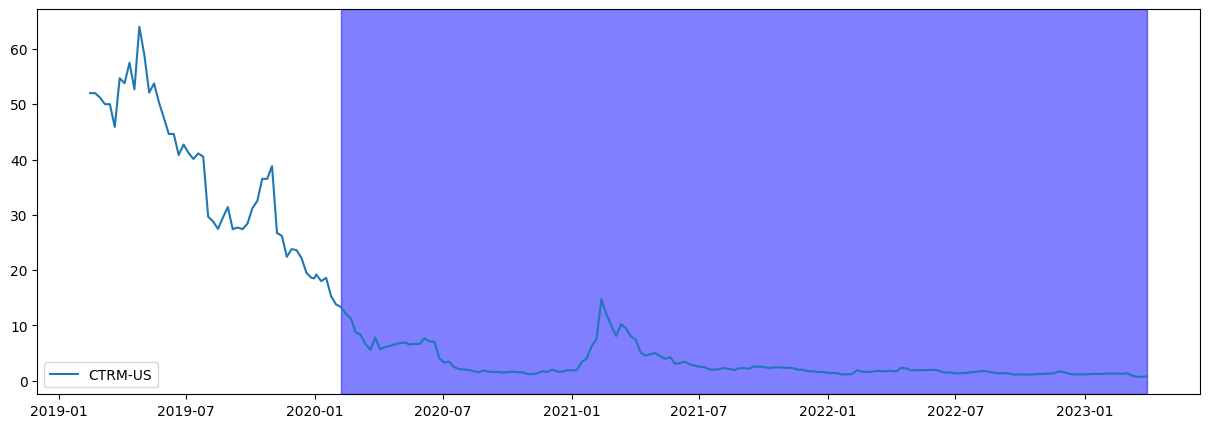

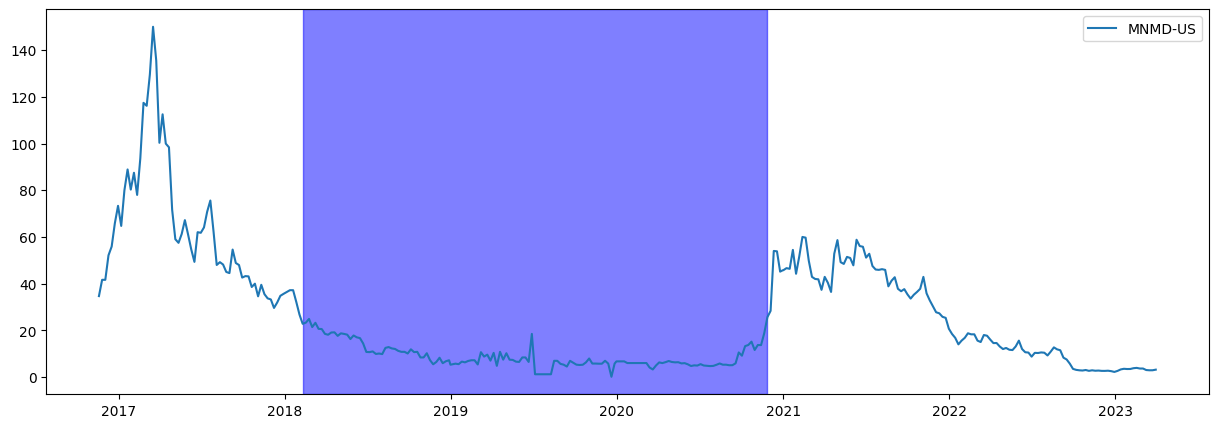

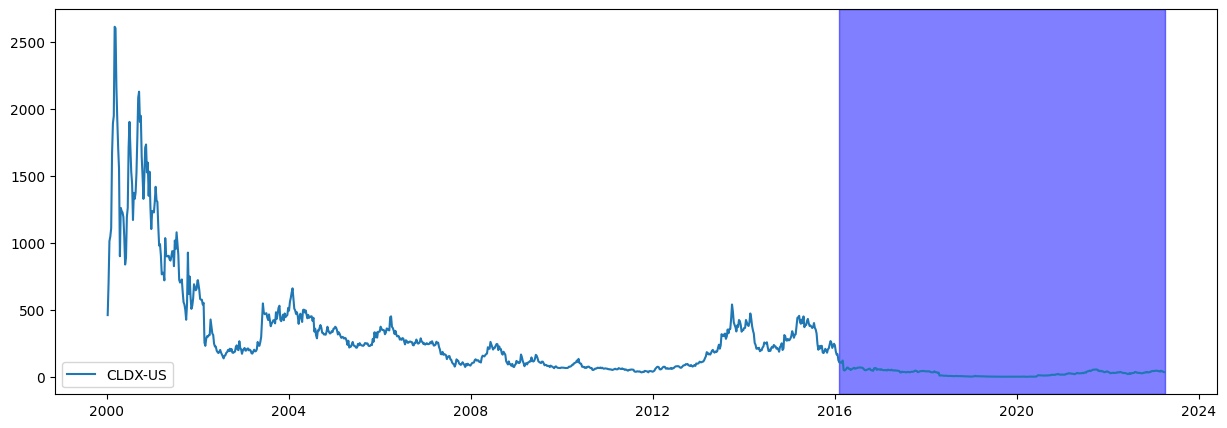

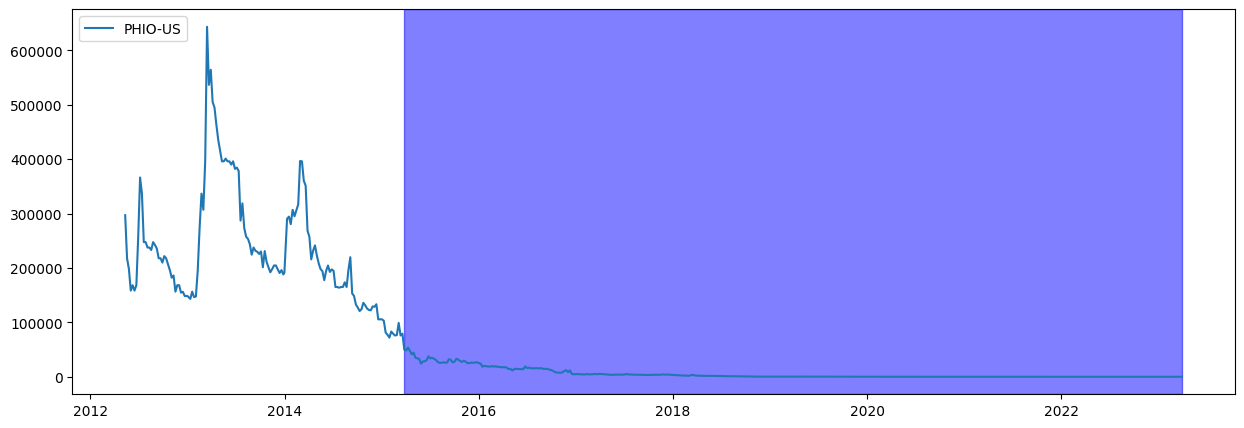

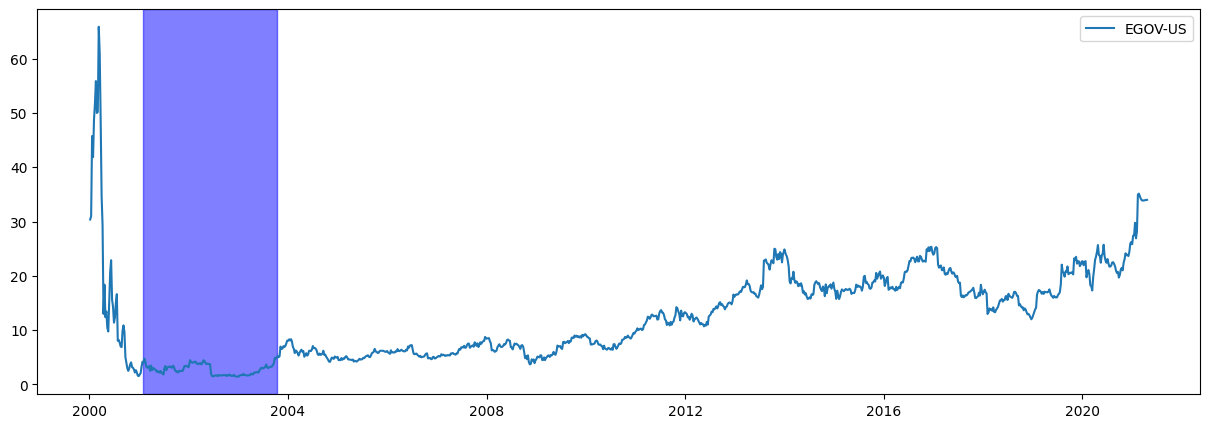

In [18]:
def plot_price(ticker, imp_start, imp_end):
    query = f"""SELECT s.fsym_id, s.ticker_region, p.p_date, p.p_price, splits.p_split_date, splits.p_split_factor FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                INNER JOIN fp_basic_prices p ON p.fsym_id = sc.fsym_regional_id
                LEFT JOIN fp_basic_splits AS splits ON splits.p_split_date = p.p_date AND p.fsym_id = splits.fsym_id 
                WHERE s.ticker_region = "{ticker}" AND p.p_date >= '2000-01-01'
                ORDER BY s.fsym_id, p.p_date"""
    
    adj = spark.sql(query)
    adj = adj.withColumn("temp_cum_split_factor", when(adj.p_date==adj.p_split_date, lit(adj.p_split_factor)).otherwise(lit(1.0)))
    adj = adj.withColumn("cum_split_factor", lit(0.0))

    window_spec = Window.partitionBy('fsym_id').orderBy(F.desc('p_date'))

    adj = adj.withColumn('cum_split_factor_no_lag', 
                        F.exp(F.sum(F.log('temp_cum_split_factor')).over(window_spec)))#calculate cumulative split factor

    adj = adj.withColumn('cum_split_factor', 
                        F.when(F.row_number().over(window_spec) == 1, 1.0)
                        .otherwise(F.lag('cum_split_factor_no_lag', default=1.0).over(window_spec)))

    adj = adj.withColumn('split_adj_price', adj.p_price * adj.cum_split_factor)
    
    adj = adj.withColumn('year', F.year('p_date'))
    
    adj =adj.withColumn('week_of_year', F.weekofyear('p_date'))

    window_spec = Window.partitionBy('fsym_id', 'year', 'week_of_year').orderBy(col('p_date').desc())

    adj = adj.withColumn('row_num', F.row_number().over(window_spec))

    adj = adj.filter(col('row_num') == 1).orderBy('p_date')
    adj = adj.drop('temp_cum_split_factor', 'cum_split_factor', 'cum_split_factor_no_lag', 'row_num', 'p_split_date', 'p_split_factor')
    
    adj_pd = adj.toPandas()
    adj_pd['p_date'] = pd.to_datetime(adj_pd['p_date'])

    plt.figure(figsize=(15, 5))
    plt.plot(adj_pd['p_date'], adj_pd['split_adj_price'], label=ticker)
    plt.axvspan(imp_start, imp_end, alpha=0.5, color='blue')
    plt.legend()
    plt.show()


    
#plot_price('ABVC')
imp_df = pd.read_csv('imploded_stocks3.csv', index_col=False)
imps_only = imp_df.loc[imp_df['Implosion_Start_Date'].notnull()].head(5)
for idx, row in imps_only.iterrows():
    plot_price(row['ticker_region'], row['Implosion_Start_Date'], row['Implosion_End_Date'])
    

In [19]:
len(imps_only)

5

In [8]:
#spark.stop()